<a href="https://colab.research.google.com/github/drscicomm/food-security/blob/main/LDA_viz_C_20210924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive and Upload Text Corpus

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# upload file
from google.colab import files
uploaded = files.upload()

Saving text.xlsx to text.xlsx


Set up environment

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'base', 'show', 'time', 'provide', 'project', 'ai', 'marry', 'food', 'set', 'number', 'datum', 'model', 'cell', 'study', 'research', 'collection', 'studies', 'determine', 'table', 'variable', 'abstract', 'results', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'english' + 'high' + 'given' + 'november' + 'also' + 'na' + 'may' + 'yes' + 'log' + 'lev' + 'wwwplosoneorg' + 'used' + 'plosone' + 'using' + 'et' + '1b' + 'iii' + 'one' + 'two' + 'use' + 'plos' + 'al' + 'gi' + 'j' + 'ic' + 'ur' + 'sd' + 'ar' + 'fs' + 'gi' + 'f' + 'b' + 'es'])

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
pip install openpyxl==3.0.7

In [ ]:
import os

os.chdir('..')

Load excel file and read into pandas dataframe

In [ ]:
# Read data into dataframe
df = pd.read_excel('/text.xlsx')

In [ ]:
# Print head
df.head()

,author,year,paper_text,index
0,Madichetty,2020,Social media platform like Twitter is one of t...,0
1,Eyre,2021,Background: Achieving food security remains a ...,1
2,Gadzalo,2020,\n\nAbstract\nThe methodological approach for ...,2
3,Nica-Avram 2021,2021,\nFood insecurity in the UK has captured publi...,3
4,Shi,2021,\n\nis only making things worse [22]. Even aft...,4


In [ ]:
#drop spaces
df = df.dropna(subset=['paper_text'])

Preprocessing

In [ ]:
# Remove punctuation
df['paper_text_processed'] = \
df['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['paper_text_processed'] = \
df['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of df
df['paper_text_processed'].head()

0    social media platform like twitter is one of t...
1    background: achieving food security remains a ...
2    \n\nabstract\nthe methodological approach for ...
3    \nfood insecurity in the uk has captured publi...
4    \n\nis only making things worse [22] even afte...
Name: paper_text_processed, dtype: object

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.paper_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['social', 'media', 'platform', 'like', 'twitter', 'is', 'one', 'of', 'the', 'primary', 'sources', 'for', 'sharing', 'real', 'time', 'information', 'at', 'the', 'time', 'of', 'events', 'such', 'as', 'disasters', 'political', 'events', 'etc', 'detecting', 'the', 'resource', 'tweets', 'during', 'disaster', 'is', 'an', 'essential', 'task', 'because', 'tweets', 'contain', 'different', 'types', 'of', 'information', 'such', 'as', 'infrastructure', 'damage', 'resources', 'opinions', 'and', 'sympathies', 'of', 'disaster', 'events', 'etc', 'tweets', 'are', 'posted', 'related', 'to', 'need', 'and', 'availability', 'of', 'resources', 'nar', 'by', 'humanitarian', 'organizations', 'and', 'victims', 'hence', 'reliable', 'methodologies', 'are', 'required', 'for', 'detecting', 'the', 'nar', 'tweets', 'during', 'disaster', 'the', 'existing', 'works', 'don', 'focus', 'well', 'on', 'nar', 'tweets', 'detection', 'and', 'also', 'had', 'poor', 'performance', 'hence', 'this', 'paper', 'focus', 'on', 'detect

Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Determine optimal number of topics, *c_v*

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus,  int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
model_results1 = pd.DataFrame(model_results)
model_results1.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.246247
1,75% Corpus,2,0.01,0.31,0.254319
2,75% Corpus,2,0.01,0.61,0.251298
3,75% Corpus,2,0.01,0.91,0.258413
4,75% Corpus,2,0.01,symmetric,0.251298


Text(0.5, 1.0, 'Topic coherence')

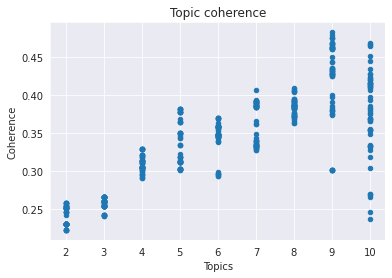

In [ ]:

# Show graph

model_results1.plot(x ='Topics', y='Coherence', kind = 'scatter')
plt.title('Topic coherence')

In [ ]:
# coherence scores, alpha and beta set at .01
# upload file
from google.colab import files
uploaded = files.upload()

Saving coherence scores alpha beta .01.xlsx to coherence scores alpha beta .01.xlsx


In [ ]:
# Read data into dataframe
coherence_topics = pd.read_excel('/coherence scores alpha beta .01.xlsx')

In [ ]:
coherence_topics.head()

,Topics,Coherence
0,2,0.246247
1,3,0.253481
2,4,0.318433
3,5,0.334666
4,6,0.358344


Text(0.5, 1.0, 'Topic coherence')

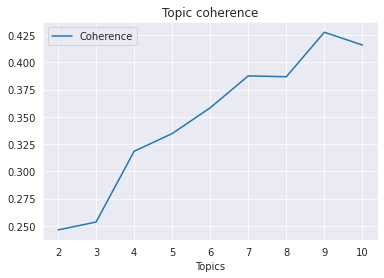

In [ ]:
# Show graph

coherence_topics.plot(x ='Topics', y='Coherence', kind = 'line')
plt.title('Topic coherence')

In [ ]:
uploaded = files.upload()

Saving 100% corpus coherence scores alpha beta .01.xlsx to 100% corpus coherence scores alpha beta .01.xlsx


In [ ]:
# Read data into dataframe
all_coherence_topics = pd.read_excel('/100% corpus coherence scores alpha beta .01.xlsx')

Text(0.5, 1.0, 'Topic coherence')

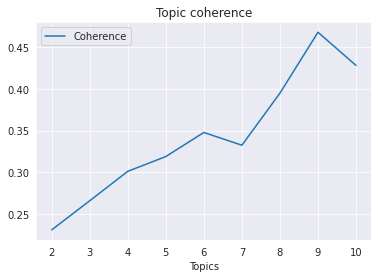

In [ ]:
all_coherence_topics.plot(x ='Topics', y='Coherence', kind = 'line')
plt.title('Topic coherence')

In [ ]:
# select best alpha and beta parameters ( for k = 9, look at highest coherence score and select corresponding alpha and beta)
uploaded = files.upload()

Saving select best alpha beta.xlsx to select best alpha beta.xlsx


In [ ]:
# Read data into dataframe
best_alphabeta = pd.read_excel('/select best alpha beta.xlsx')

In [ ]:
best_alphabeta.head()

,Topics,Alpha,Beta,Coherence
0,9,asymmetric,0.31,0.435962
1,9,0.61,0.31,0.435871
2,9,0.31,0.31,0.434747
3,9,symmetric,0.31,0.434747
4,9,0.91,0.31,0.434599


Choosing Alpha=asymmetric, Beta=.31 k=9

Build the topic model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='asymmetric',
                                            eta=.31,
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.037*"churn" + 0.015*"client" + 0.015*"benefit" + 0.014*"state" + '
  '0.012*"cost" + 0.012*"government" + 0.010*"recertification" + '
  '0.010*"program" + 0.009*"agency" + 0.008*"fraud"'),
 (1,
  '0.020*"snap" + 0.019*"household" + 0.009*"new" + 0.009*"recipient" + '
  '0.007*"topic" + 0.007*"program" + 0.006*"exist" + 0.006*"insecurity" + '
  '0.006*"include" + 0.005*"level"'),
 (2,
  '0.011*"amount" + 0.010*"supermarket" + 0.009*"receive" + 0.008*"bank" + '
  '0.006*"warehouse" + 0.006*"layer" + 0.006*"event" + 0.005*"method" + '
  '0.005*"approximation" + 0.005*"regional"'),
 (3,
  '0.000*"security" + 0.000*"blockchain" + 0.000*"level" + 0.000*"measure" + '
  '0.000*"household" + 0.000*"insecurity" + 0.000*"drone" + 0.000*"grateful" + '
  '0.000*"coordinator" + 0.000*"relentlessly"'),
 (4,
  '0.034*"tweet" + 0.016*"classifier" + 0.011*"sentiment" + 0.010*"word" + '
  '0.009*"feature" + 0.007*"trend" + 0.006*"propose" + 0.006*"dataset" + '
  '0.006*"negative" + 0.006*"posit

What is the Dominant topic and its percentage contribution in each document

In [33]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(28)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9995,"tweet, classifier, sentiment, word, feature, trend, propose, dataset, negative, positive","[platform, twitter, primary, source, share, real, information, event, disaster, political, event..."
1,1,6.0,0.9043,"system, rescue, value, volunteer, network, donation, forecast, give, problem, expert","[background, achieve, security, remain, key, challenge, public, policy, world, understanding, de..."
2,2,5.0,0.9087,"demand, change, country, product, increase, structure, consumer, value, pandemic, flour","[methodological, approach, assess, formation, demand, unforeseen, situation, digital, internet, ..."
3,3,1.0,0.8563,"snap, household, new, recipient, topic, program, exist, insecurity, include, level","[insecurity, capture, public, attention, however, estimate, prevalence, deeply, share, contentio..."
4,4,6.0,0.9996,"system, rescue, value, volunteer, network, donation, forecast, give, problem, expert","[thing, bad, pandemic, hit, increase, struggle, basic, security, challenge, waste, insecurity, a..."
5,5,7.0,0.9996,"security, household, level, measure, class, crisis, insecurity, country, access, prediction","[globally, people, insecure, current, method, identify, insecurity, crisis, statistical, fail, s..."
6,6,8.0,0.9995,"mention, hurricane, twitter, healthy, tweet, category, list, day, group, examine","[little, known, beverage, common, goal, track, high, frequency, mention, hurricane, affect, quan..."
7,7,1.0,0.7865,"snap, household, new, recipient, topic, program, exist, insecurity, include, level","[insecurity, persistent, pernicious, problem, due, logistical, challenge, national, insecurity, ..."
8,8,1.0,0.7627,"snap, household, new, recipient, topic, program, exist, insecurity, include, level","[nowcaste, forecasting, stamp, recipient, perform, large, sample, forecasting, exercise, almost,..."
9,9,6.0,0.9994,"system, rescue, value, volunteer, network, donation, forecast, give, problem, expert","[bank, collect, distribute, donation, statistical, technique, apply, donation, fore, partner, ag..."


In [ ]:
# save as CSV
df_dominant_topic.to_csv('df_dominant_topic.csv')

The most representative sentence for each topic

In [34]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(8)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6359,"churn, client, benefit, state, cost, government, recertification, program, agency, fraud","[recently, suggest, tremendous, fraud, government, welfare, program, little, evidence, back, cla..."
1,1.0,0.9996,"snap, household, new, recipient, topic, program, exist, insecurity, include, level","[expand, significantly, great, recession, important, buffer, family, characterize, new, group, r..."
2,4.0,0.9995,"tweet, classifier, sentiment, word, feature, trend, propose, dataset, negative, positive","[platform, twitter, primary, source, share, real, information, event, disaster, political, event..."
3,5.0,0.9087,"demand, change, country, product, increase, structure, consumer, value, pandemic, flour","[methodological, approach, assess, formation, demand, unforeseen, situation, digital, internet, ..."
4,6.0,0.9996,"system, rescue, value, volunteer, network, donation, forecast, give, problem, expert","[thing, bad, pandemic, hit, increase, struggle, basic, security, challenge, waste, insecurity, a..."
5,7.0,0.9996,"security, household, level, measure, class, crisis, insecurity, country, access, prediction","[globally, people, insecure, current, method, identify, insecurity, crisis, statistical, fail, s..."
6,8.0,0.9995,"mention, hurricane, twitter, healthy, tweet, category, list, day, group, examine","[little, known, beverage, common, goal, track, high, frequency, mention, hurricane, affect, quan..."


In [ ]:
sent_topics_sorteddf_mallet.to_csv('topics.csv')

Frequency Distribution of Word Counts in Documents

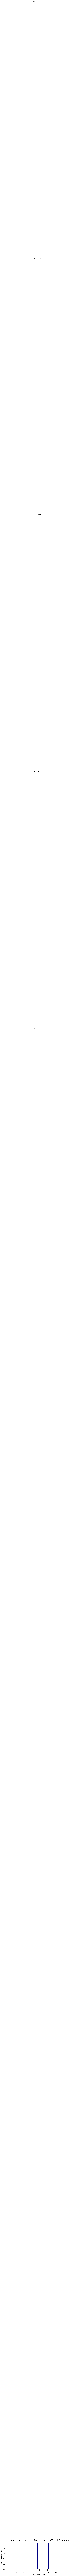

In [35]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,3.5), dpi=160)
plt.hist(doc_lens, bins = 2000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 2000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,2000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


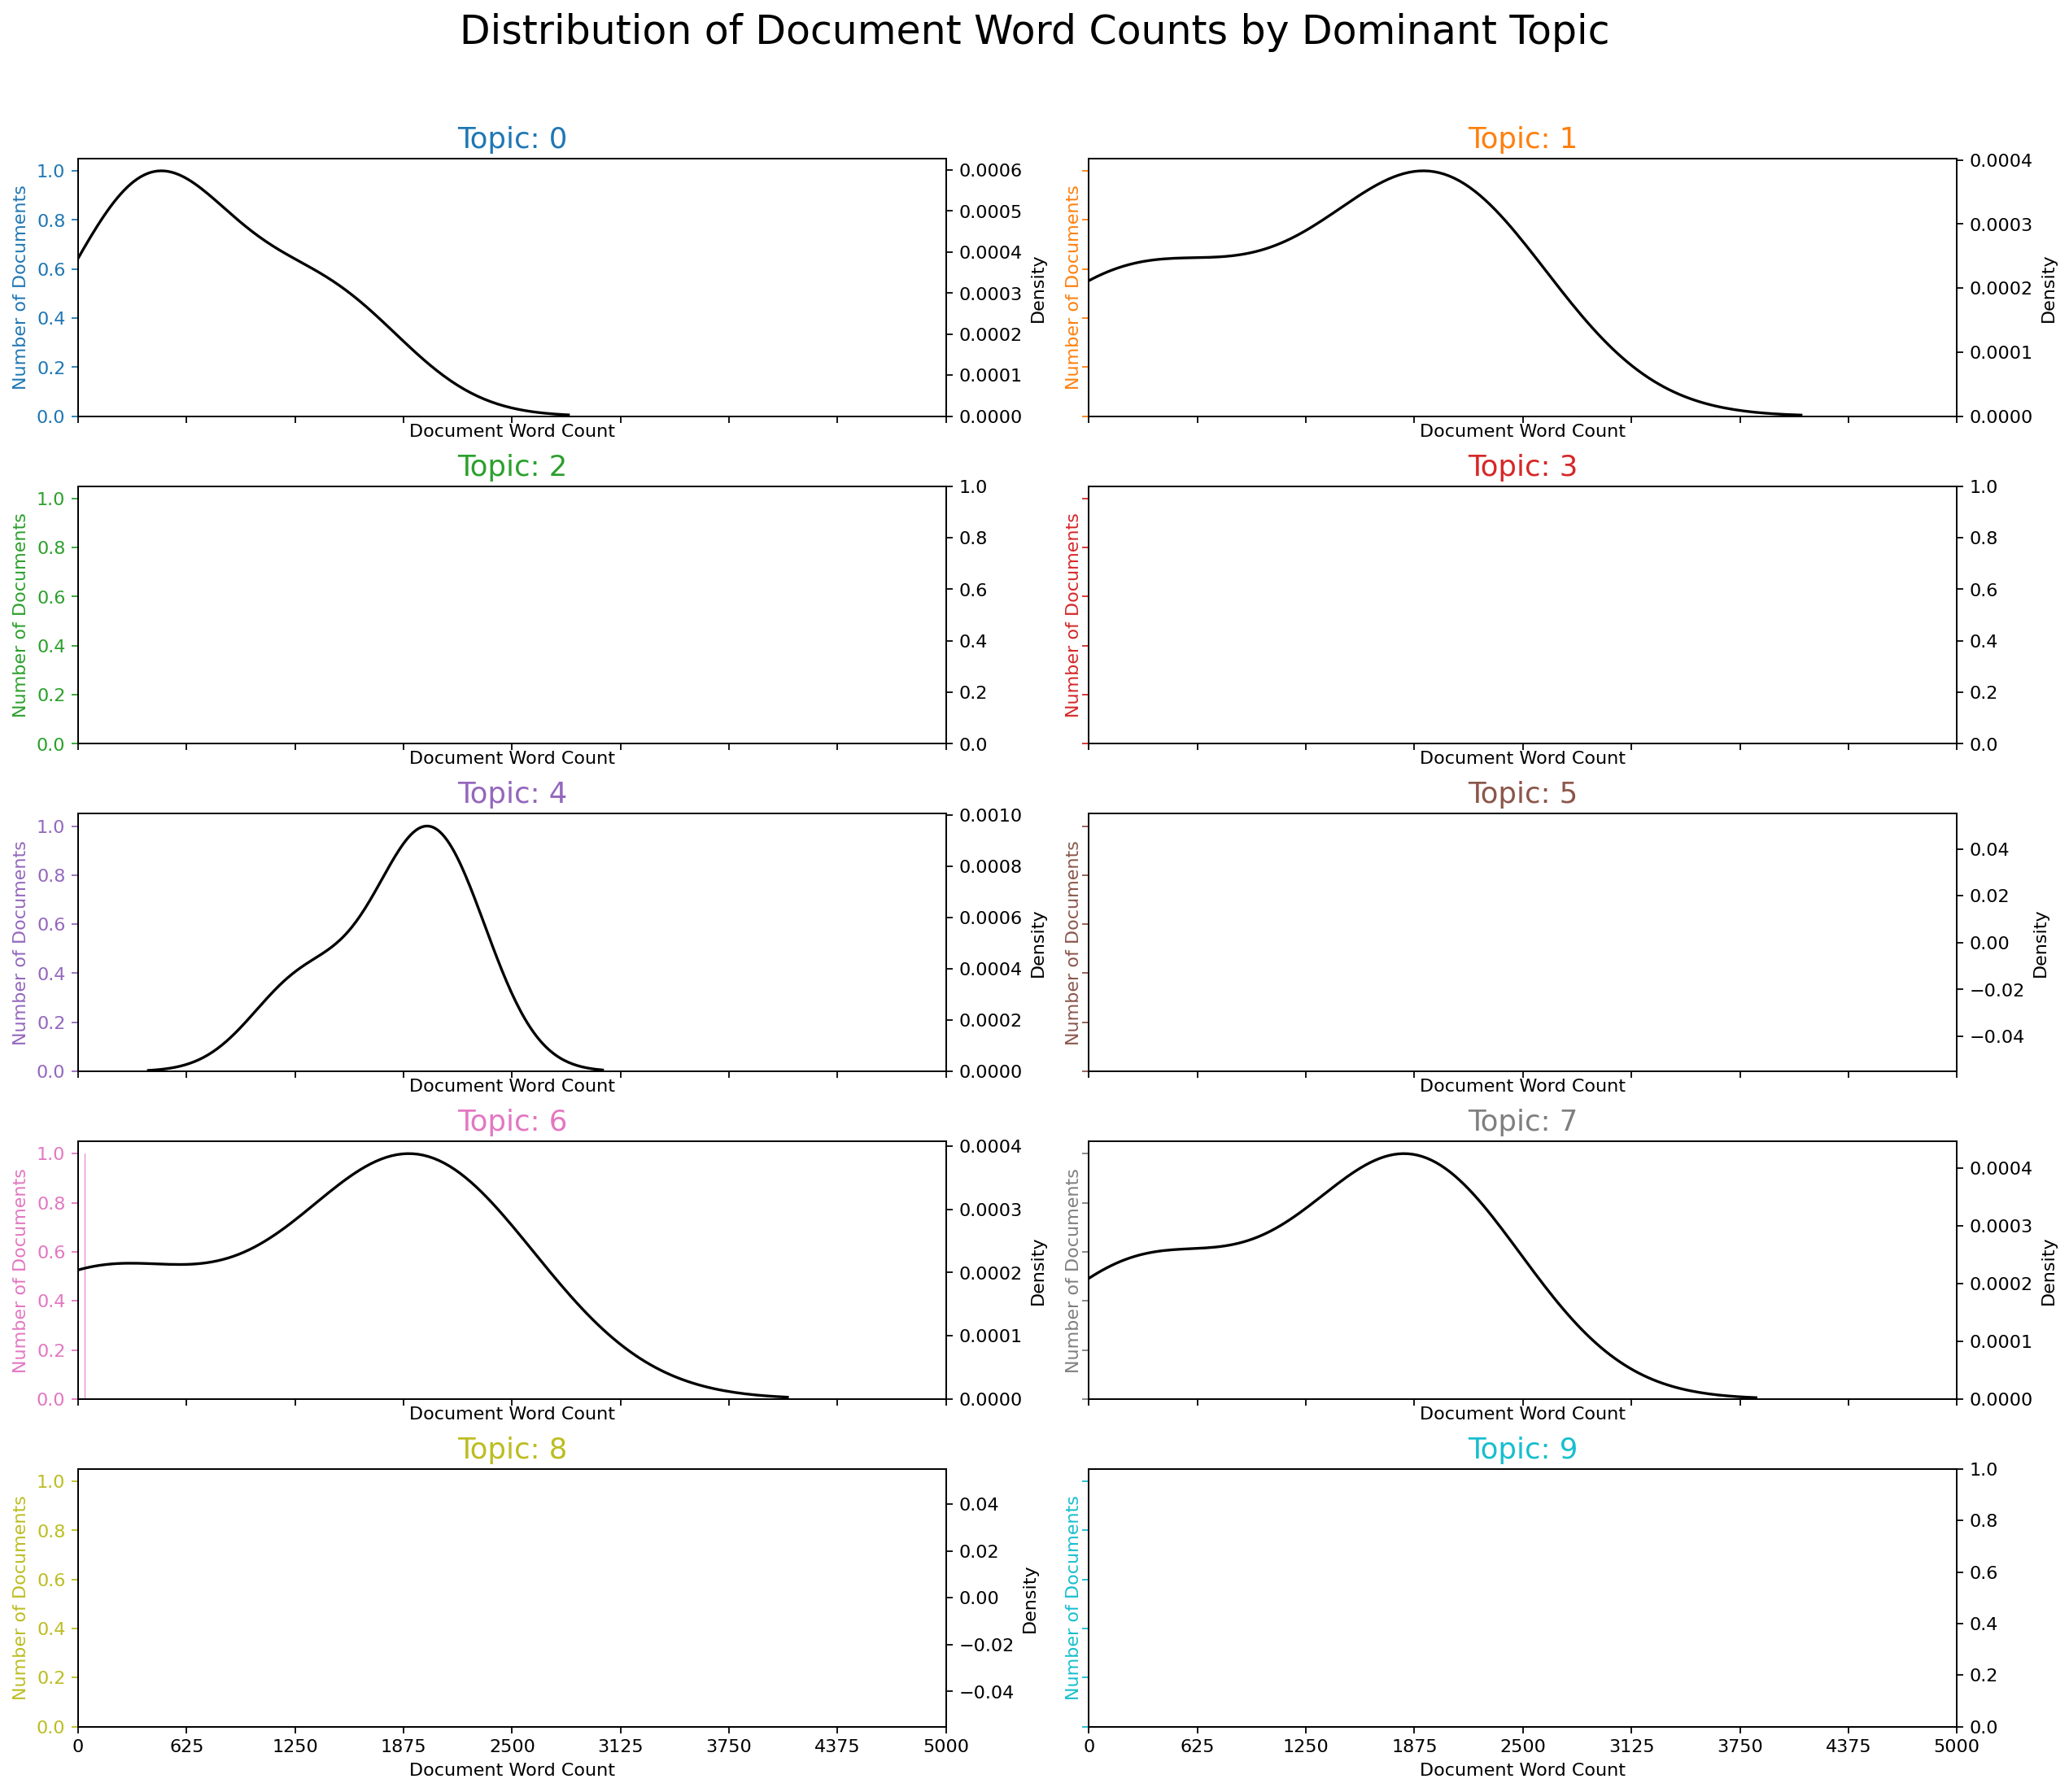

In [36]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 5000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 5000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,5000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Word clouds

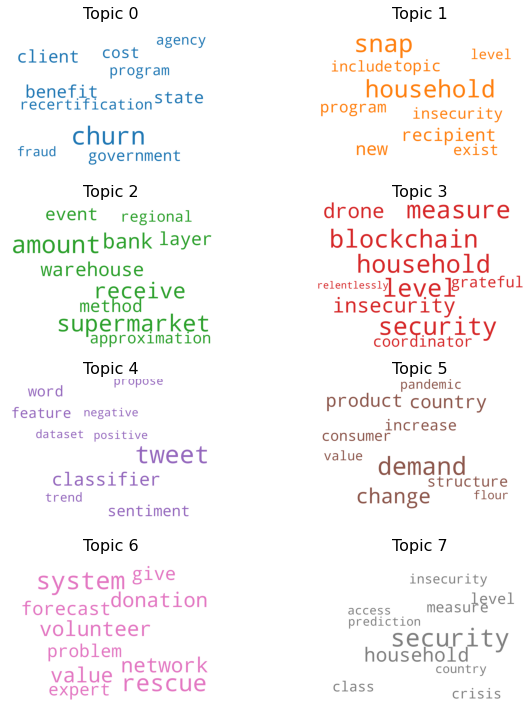

In [37]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word Counts of Topic Keywords

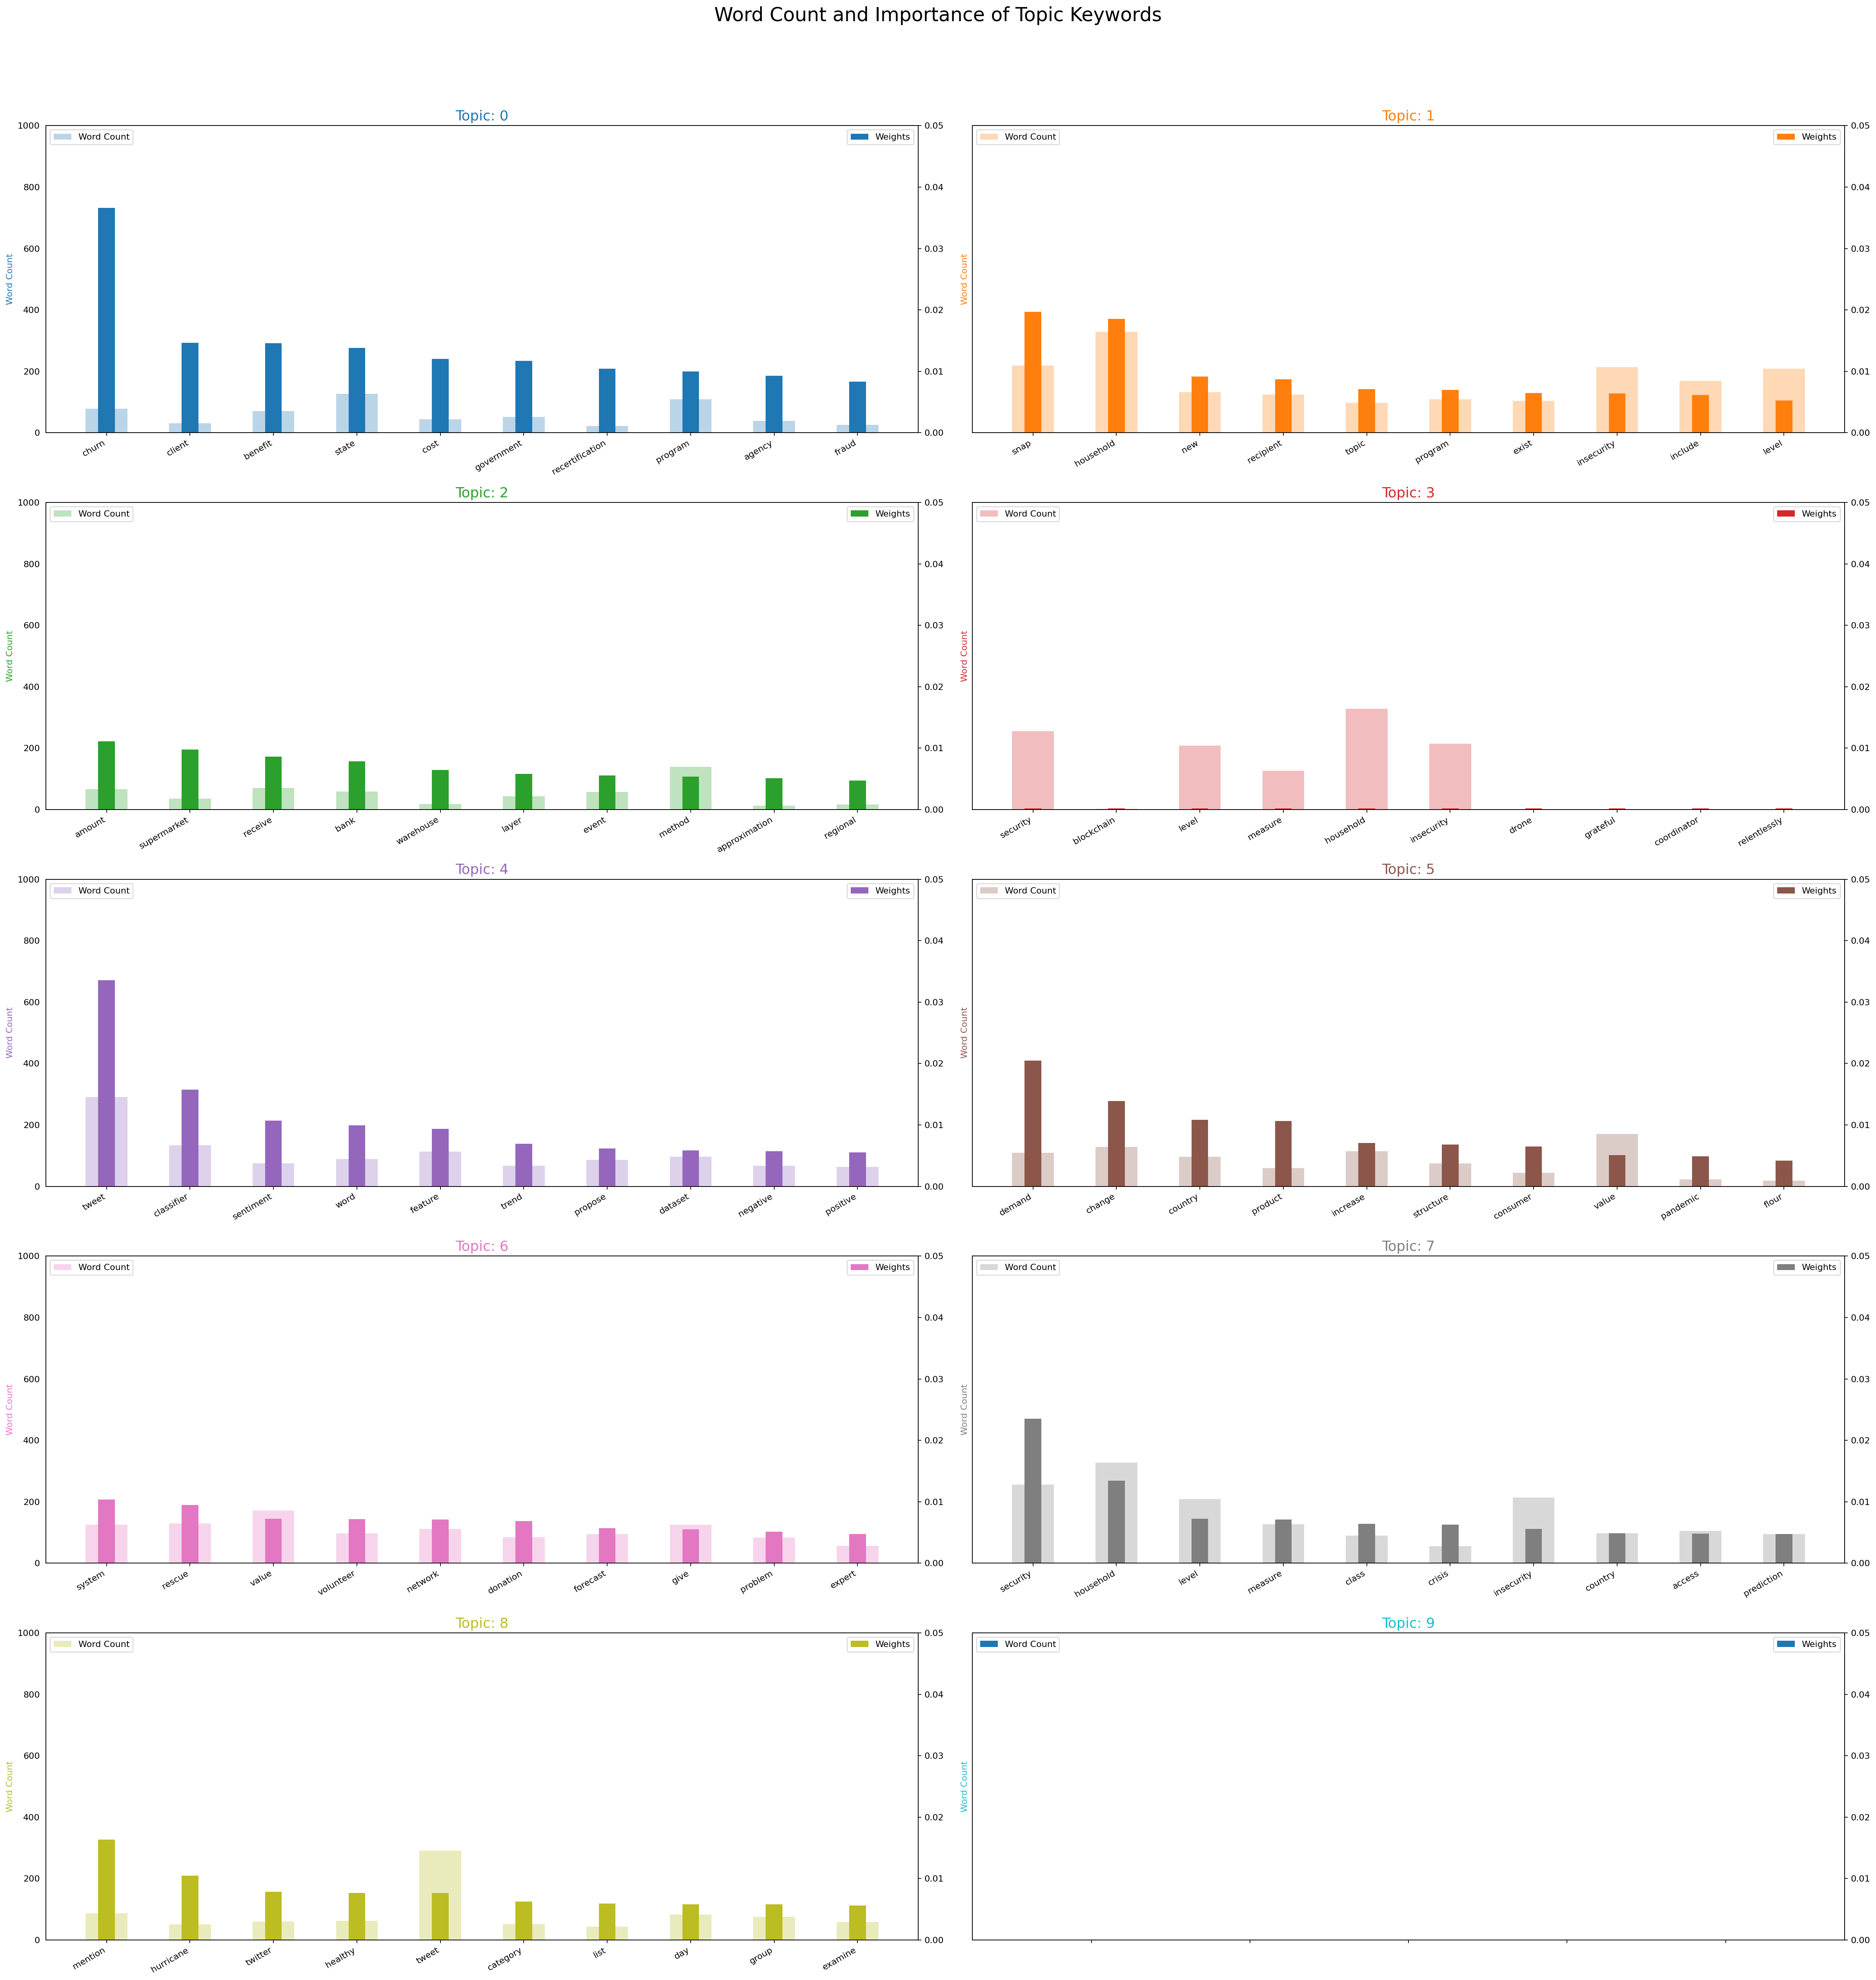

In [38]:
# When it comes to the keywords in the topics, the importance (weights) of the keywords matters. 
# Along with that, how frequently the words have appeared in the documents is also interesting to look.
# Let’s plot the word counts and the weights of each keyword in the same chart.
#You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency 
# is more than the weight. Often such words turn out to be less important. 
# The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and 
# re-running the training process.

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(30,30), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Sentence Chart Colored by Topic

> Each word in the document is representative of one of the 8 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.



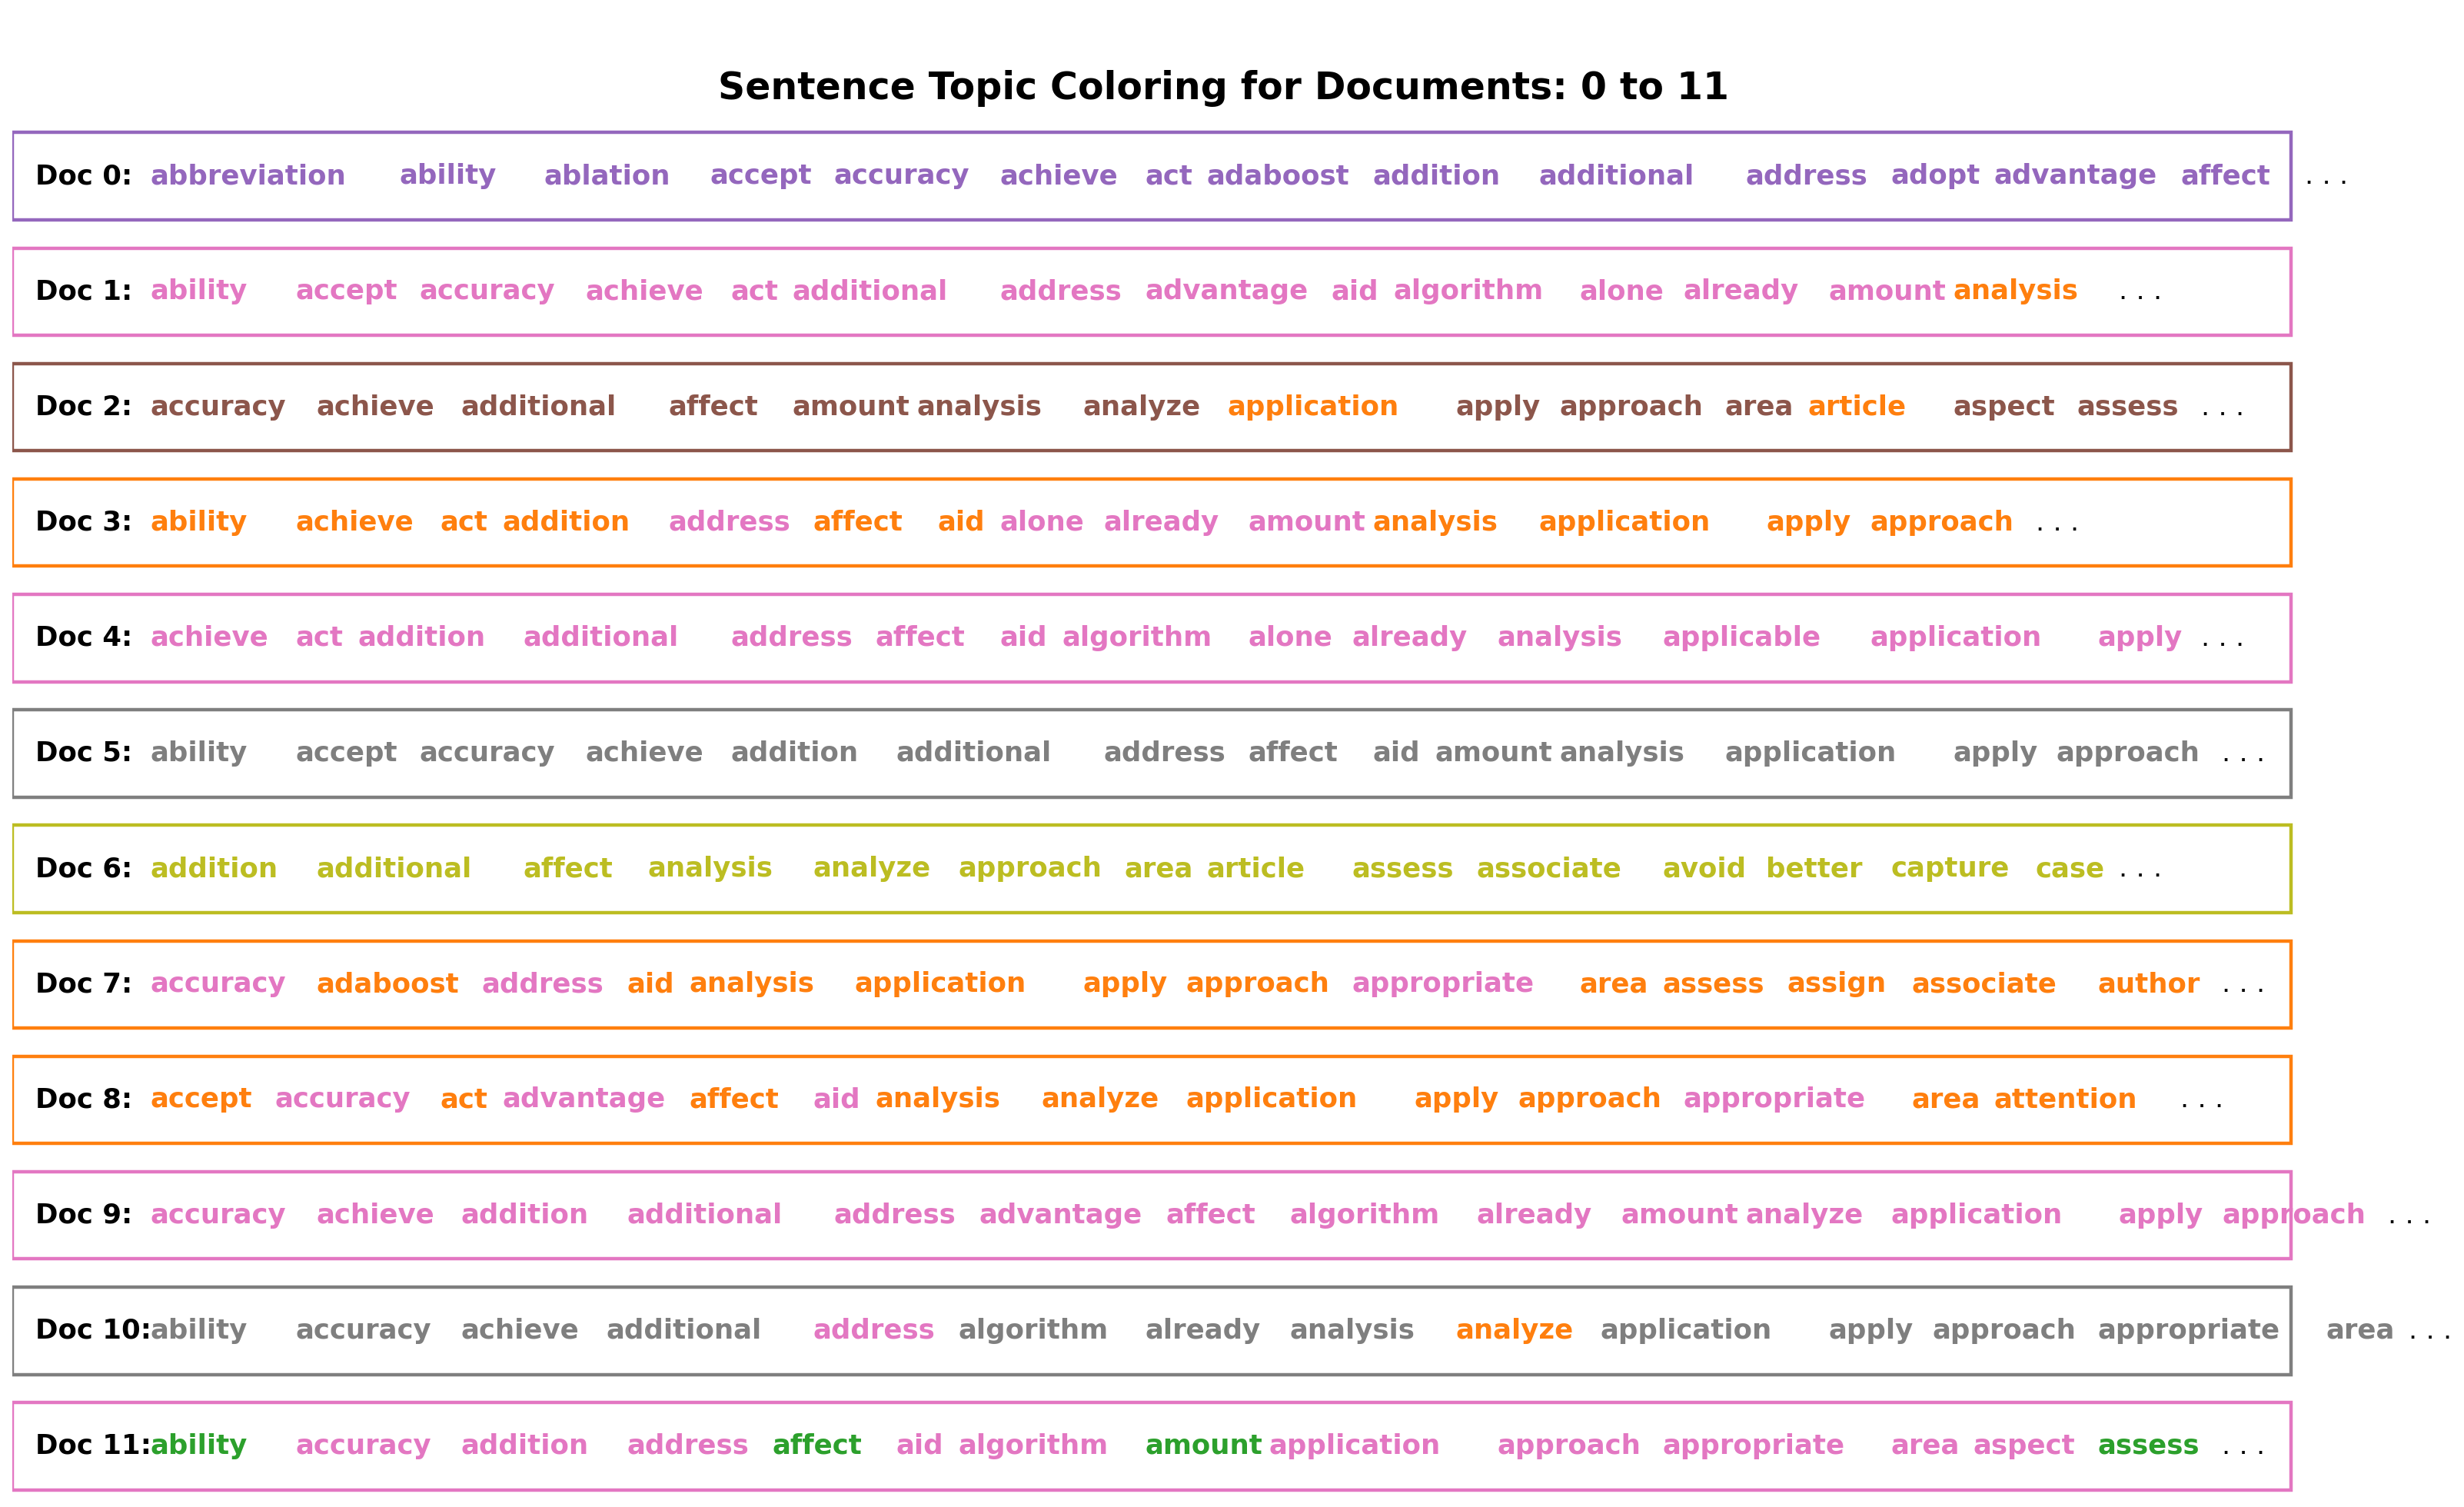

In [39]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

What are the most discussed topics in the documents?

In [46]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

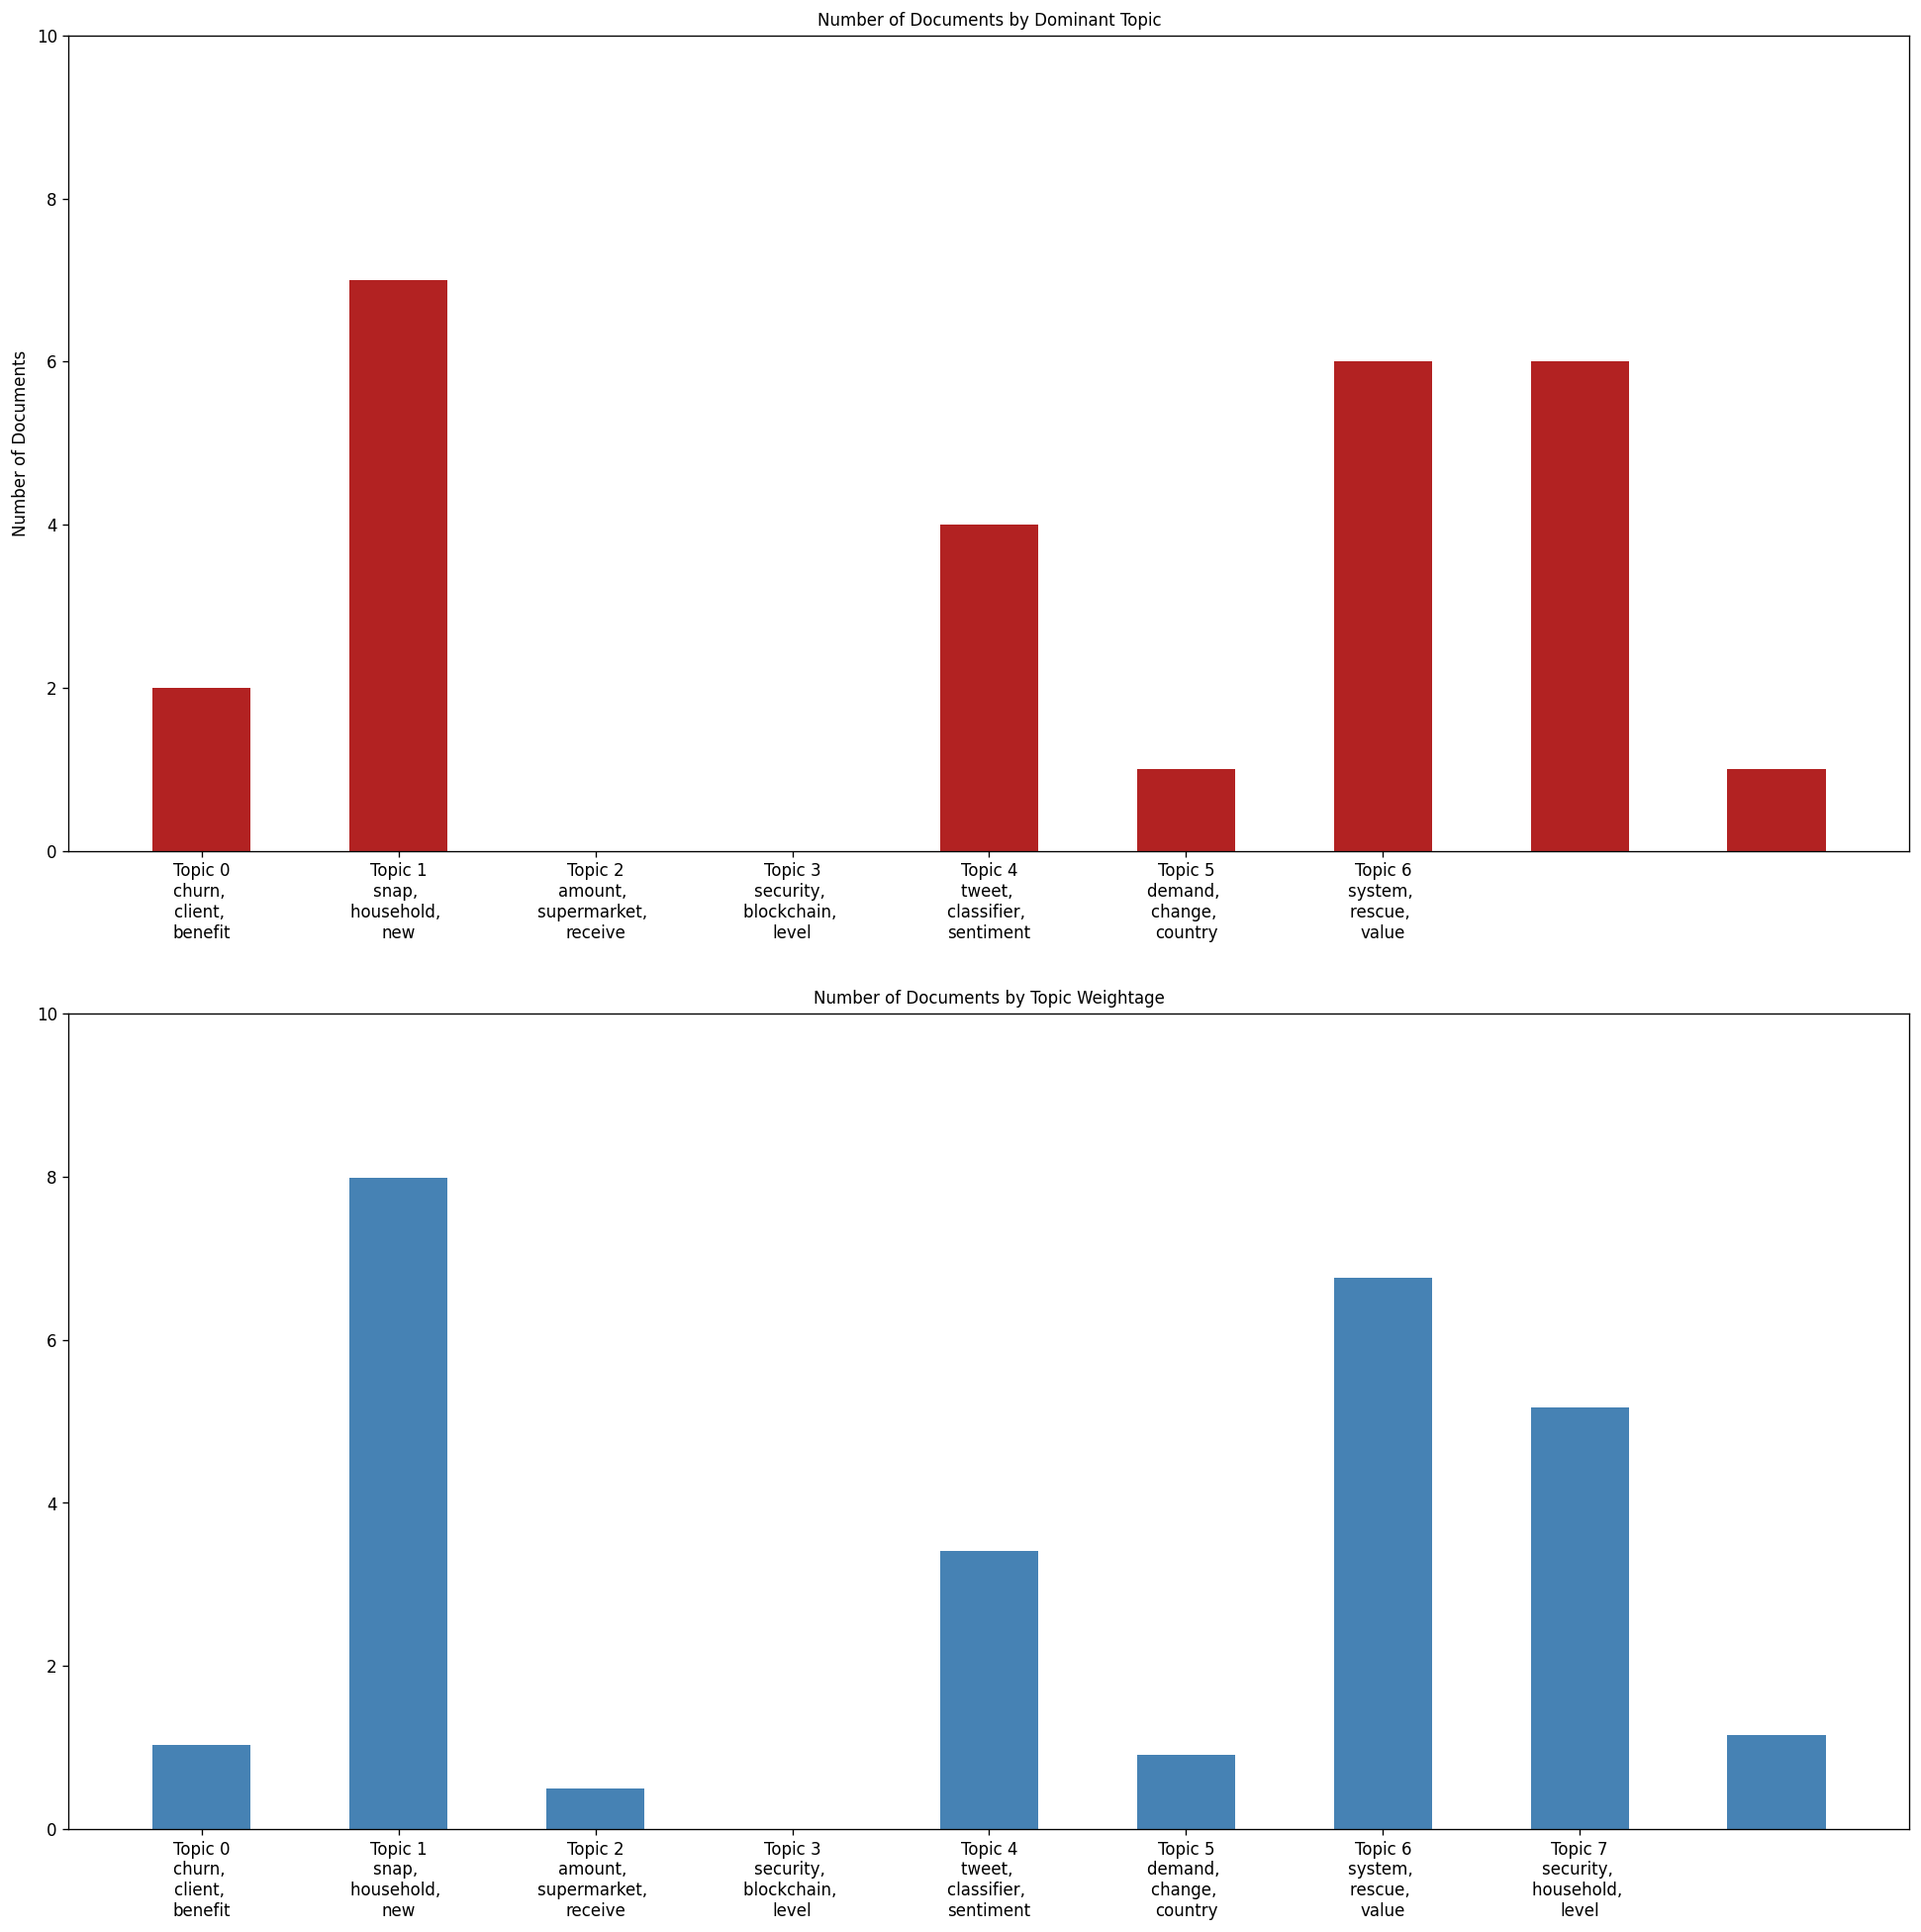

In [47]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 10)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

t-SNE Clustering Chart

In [42]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.386650
[t-SNE] KL divergence after 1000 iterations: 0.458140


In [43]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 9
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:
pip install pyLDAvis

In [44]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [45]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.118481  0.110301       1        1  28.223557
6      0.112490  0.003062       2        1  23.983967
7      0.085257  0.026962       3        1  16.560715
4      0.061568 -0.142828       4        1  15.337902
8     -0.042205 -0.039255       5        1   5.523632
5     -0.038110 -0.001016       6        1   4.638499
0     -0.148131  0.073701       7        1   3.246789
2     -0.073903 -0.019065       8        1   2.476997
3     -0.075447 -0.011862       9        1   0.007943, topic_info=               Term        Freq       Total Category  logprob  loglift
507           tweet  216.000000  216.000000  Default  30.0000  30.0000
3161           snap  217.000000  217.000000  Default  29.0000  29.0000
1035       security  205.000000  205.000000  Default  28.0000  28.0000
797       household  293.000000  293.000000  Default  27.0000  27.0000
81       classifier   95.000000   95.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
4692  topographical    0.000617    3.552069   Topic9  -8.5093   0.7833
4693         triple    0.000617    3.552069   Topic9  -8.5093   0.7833
4694       unmanned    0.000617    3.552069   Topic9  -8.5093   0.7833
79            class    0.000617   62.772369   Topic9  -8.5093  -2.0887
655         country    0.000617   65.507361   Topic9  -8.5093  -2.1314

[543 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
545       1  0.528191  access
545       2  0.056190  access
545       3  0.348381  access
545       4  0.056190  access
545       6  0.011238  access
...     ...       ...     ...
541       5  0.011606    year
541       6  0.011606    year
1574      1  0.071701    zone
1574      3  0.788712    zone
1574      6  0.071701    zone

[1144 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 5, 9, 6, 1, 3, 4])